### 데이터 정제

- 60GB가 넘는 데이터를 처리하기 위해 Google Cloud Storage (GCS) 에 모든 데이터 적재

- 전처리
    - “핫플레이스” 예측을 콘셉트에 맞게, 고정 상주인구가 대다수인 “주중” 데이터 제외 (주말만 사용)
    - 한 달 단위의 데이터를 쿼터 단위로 변경 (ex. [1,2,3] → 1Q)
        - 상권데이터가 쿼터 단위로 제공되기 때문에 두 데이터의 연결성 강화
    - 이동유형을 고려해서 집과 회사로 표시된 이동 유형은 제거
    - 11, 13, 41 등으로 자세하게 표현된 나이를 10대, 20-30대 형식으로 변환
    - [행정동, 성별, 나이, 요일, 도착시간, Year, Quarter, 이동인구] 를 남겨두고 나머지 Feature 제거
    
- 가장 작은 용량의 파일들을 GCS에 저장한뒤, local에서  전처리하고 Concat하는 방식으로 데이터 정제
    - 가장 작은 용량의 파일도 전처리 하는데 30분 이상이 소요됨
    - API를 써서 Local 에서 GCS 내의 데이터를 변경할 수 있는 파이프라인 제작해 전처리 과정을 자동화했기 때문에, 남는 시간 ( 수면 시간 )에 전처리를 완료할 수 있었음

In [ ]:
from google.cloud import storage
from google.oauth2 import service_account
import pandas as pd
from io import StringIO
import os
import argparse
import numpy as np
from tqdm import tqdm

parser = argparse.ArgumentParser()

parser.add_argument('--year', required=False, help='데이터 연도', default="2023")

args = parser.parse_args()

year = args.year

key_path = 'C:\\Users\\Jeong Hyunji\\Downloads\\datamining-405806-6d75fb5337bb.json'

client = storage.Client.from_service_account_json(key_path)

bucket_name = "ys_dm_data"

bucket = client.bucket(bucket_name)

def return_bucket(bucket_name) :

    return client.bucket(bucket_name)

def list_blobs_per_year(bucket_name,starts,ends):

    blobs = client.list_blobs(f"{bucket_name}")

    file_lst = [] 

    for blob in blobs:

        name = blob.name
        
        if name.startswith(starts) & name.endswith(ends) :

            file_lst.append(name)

    return file_lst


def read_csv_from_gcs(read_blob_name):

    blob = bucket.blob(read_blob_name)

    # Download the CSV content from GCS
    content = blob.download_as_string().decode("CP949")

    # Create a DataFrame from the CSV content

    df = pd.read_csv(StringIO(content))
    
    return df

region_code = pd.read_excel('서울생활이동데이터_행정동코드_20210907.xlsx')
region_code = region_code[['읍면동','name']]
region_dict = {}

for i in range(len(region_code)):
    region_dict[region_code.iloc[i,0]] = region_code.iloc[i,1]

file_lst = list_blobs_per_year(bucket_name,year,".csv")

def preprocessing() :

    for file in file_lst :

        print(file)

        tmp = read_csv_from_gcs(file) 

        print(f"{file}을 읽어왔습니다.")

        tmp.drop(['출발 행정동 코드','평균 이동 시간(분)'], inplace=True, axis=1)

        seoul_idx = [True if str(i)[0] == "1" else False for i in tmp['도착 행정동 코드']]
        
        tmp = tmp[seoul_idx]

        del seoul_idx

        tmp['이동인구(합)'] = [1.5 if '*' in i  else i for i in tmp['이동인구(합)'] ]

        tmp["month"] = [int(str(i)[4:]) for i in tmp['대상연월']]

        QUARTER = []

        for i in tmp['month']:

            if i in [1,2,3]:
                QUARTER.append('1')

            elif i in [4,5,6]:
                QUARTER.append('2')

            elif  i in [7,8,9]:
                QUARTER.append('3')

            else:
                QUARTER.append('4')

        tmp['year'] = [ int(str(i)[:4]) for i in tmp['대상연월']]
        tmp['quarter'] = QUARTER
        tmp.drop(["대상연월", "month"], inplace=True, axis=1)

        del QUARTER

        age = []

        for i in tmp['나이']:
            if i < 20:
                age.append('10')
            elif 20 <= i < 40:
                age.append('20-30')
            elif 40 <= i < 60:
                age.append('40-50')
            else:
                age.append('60-')

        tmp['나이'] = age

        del age

        #이동유형 E로 끝나는거만 남기기
        move_idx = [ True if i.endswith('E') else False for i in tmp['이동유형']]
        tmp = tmp[move_idx]

        del move_idx

        #도착 행정동 코드
        tmp['도착 행정동 코드'] = [region_dict[i] for i in tmp['도착 행정동 코드']]

        print(tmp.head())

        blob = bucket.blob(f"preprocessing/{file}").upload_from_string(tmp.to_csv(), 'text/csv')

        print(f"{file} gcp에 업로드 완료")

        del tmp


preprocessing()

In [ ]:
def concat() :

    total = pd.DataFrame(columns=['도착 행정동 코드','성별','나이',"요일",'도착시간',"year", "quarter", '이동인구(합)'])

    for i in range(4):

        file_lst = list_blobs_per_year(bucket_name,"grouped",f"{str(year[i])}.csv")
        
        for j , file in enumerate(file_lst) :

            tmp = read_csv_from_gcs(file)

            total = pd.concat([total,tmp], axis=0, ignore_index=True)

            print(f"{year[i]} 년도 {j}번쨰 파일 concat!")
            print(total.shape)

    blob = bucket.blob("total.csv").upload_from_string(total.to_csv(index=False), 'text/csv')

concat()

### 데이터 불러오기

In [15]:
# 필요한 library import
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#2020 - 2023 총 4개년의 유동인구 데이터
total = pd.read_csv("total.csv")
total.head()

,도착 행정동 코드,성별,나이,요일,도착시간,year,quarter,이동인구(합)
0,가락1동,F,10,일,0,2020,2,22.27
1,가락1동,F,10,일,1,2020,2,10.02
2,가락1동,F,10,일,2,2020,2,6.00
3,가락1동,F,10,일,3,2020,2,4.08
4,가락1동,F,10,일,4,2020,2,4.08


In [8]:
com = pd.read_csv("market.csv")
com.head()

,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,폐업_률,year,quarter,점포_변화_율
0,청운효자동,CS100001,한식음식점,82,83,1,8,2020,1,-7
1,청운효자동,CS100002,중식음식점,4,4,0,0,2020,1,0
2,청운효자동,CS100003,일식음식점,11,11,9,0,2020,1,9
3,청운효자동,CS100004,양식음식점,39,39,5,3,2020,1,2
4,청운효자동,CS100005,제과점,15,16,6,6,2020,1,0


## 데이터 시각화

#### 유동인구 데이터 ( total )

- 연도별 이동 인구 추이

In [12]:
year_moving  = total.groupby(["year"])["이동인구(합)"].sum().reset_index()
year_moving

,year,이동인구(합)
0,2020,6.538358e+08
1,2021,6.952519e+08
2,2022,8.697653e+08
3,2023,7.914481e+08


In [13]:
#2023년도는 모든 월이 집계되지 않았으므로 집계된 개월수만틈을 나눠 평균을 구해줌
for i in range(len(year_moving)) :
    if year_moving.loc[i,"year"] != 2023 :
        year_moving.loc[i,"이동인구(합)"] = year_moving.loc[i,"이동인구(합)"] / 12
    else :
        year_moving.loc[i,"이동인구(합)"] = year_moving.loc[i,"이동인구(합)"] / 10

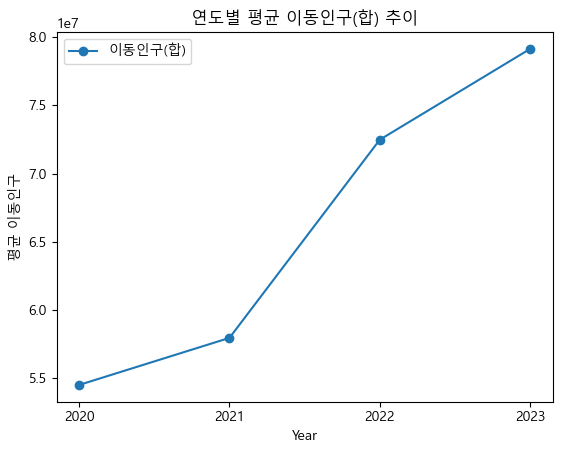

In [16]:
fig, ax = plt.subplots()

ax.plot(year_moving["year"], year_moving["이동인구(합)"], marker='o', label='이동인구(합)')

ax.set_xticks(year_moving["year"])

ax.set_xlabel('Year')
ax.set_ylabel('평균 이동인구')

ax.set_title('연도별 평균 이동인구(합) 추이')
plt.rc('font', family='Malgun Gothic') #이거안하면 한글 폰트가 깨짐

ax.legend()

plt.show()

- 쿼터별 이동인구 추이

In [17]:
quarter_moving = total.groupby(["quarter"])["이동인구(합)"].sum().reset_index()
quarter_moving

,quarter,이동인구(합)
0,1,7.085525e+08
1,2,8.397531e+08
2,3,7.829018e+08
3,4,6.790938e+08


In [18]:
#년도와 같은 맥락으로 4분기를 나눠줌
for i in range(len(quarter_moving)) :
    if quarter_moving.loc[i,"quarter"] != 4 :
        quarter_moving.loc[i,"이동인구(합)"] = quarter_moving.loc[i,"이동인구(합)"] / 12
    else :
        quarter_moving.loc[i,"이동인구(합)"] = quarter_moving.loc[i,"이동인구(합)"] / 10

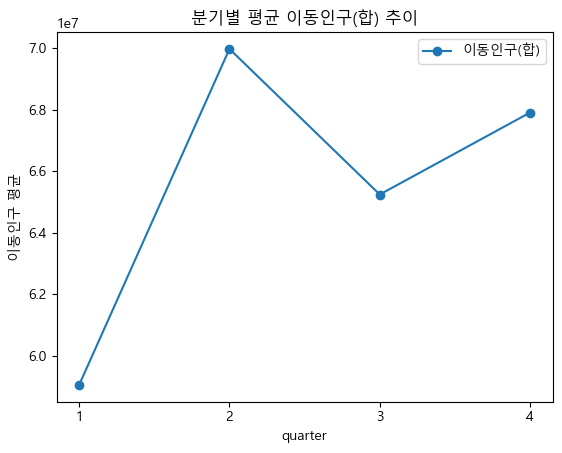

In [19]:
fig, ax = plt.subplots()

ax.plot(range(1,len(quarter_moving["quarter"])+1), quarter_moving["이동인구(합)"], marker='o', label='이동인구(합)')

ax.set_xticks(range(1,len(quarter_moving["quarter"])+1))

ax.set_xlabel('quarter')
ax.set_ylabel('이동인구 평균')
ax.set_title('분기별 평균 이동인구(합) 추이')
plt.rc('font', family='Malgun Gothic') 

ax.legend()

plt.show()

- 시점 별 

In [72]:
year_quarter  = moving_df.groupby(["year","quarter"])["이동인구(합)"].sum().reset_index()
year_quarter = year_quarter[:-1]

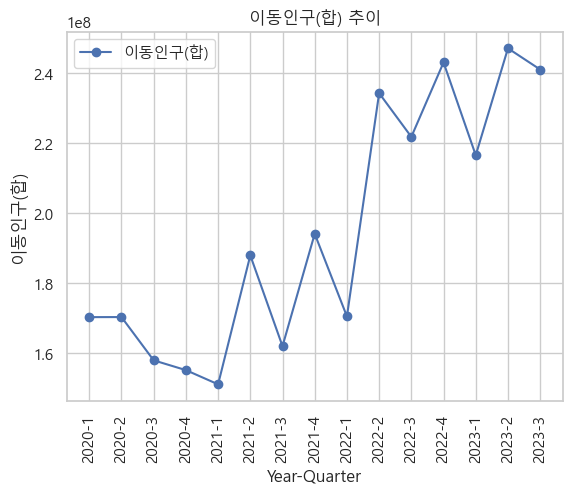

In [73]:
fig, ax = plt.subplots()

ax.plot(range(len(year_quarter["year"])), year_quarter["이동인구(합)"], marker='o', label='이동인구(합)')

ax.set_xticks(range(len(year_quarter["year"])))
ax.set_xticklabels([f'{year}-{quarter}' for year, quarter in zip(year_quarter["year"], year_quarter["quarter"])])

ax.set_xlabel('Year-Quarter')
ax.set_ylabel('이동인구(합)')
ax.set_title('이동인구(합) 추이')
plt.rc('font', family='Malgun Gothic') #이거안하면 한글 폰트가 깨짐
plt.xticks(rotation=90)

# Set the x-axis ticks and labels

ax.legend()

plt.show()

- 지역 별 유동인구

In [21]:
moving_pop = total.groupby(["도착 행정동 코드","year","quarter"])["이동인구(합)"].sum().reset_index()
moving_pop

,도착 행정동 코드,year,quarter,이동인구(합)
0,가락1동,2020,1,518979.62
1,가락1동,2020,2,541298.19
2,가락1동,2020,3,497626.60
3,가락1동,2020,4,532501.79
4,가락1동,2021,1,505503.21
...,...,...,...,...
6763,흑석동,2022,4,569851.89
6764,흑석동,2023,1,497639.91
6765,흑석동,2023,2,593820.44
6766,흑석동,2023,3,535120.82


In [22]:
moving_pop["이동인구(평균)"] = moving_pop.apply(lambda x : x["이동인구(합)"] if (x["year"] == 2023 and x["quarter"] ==4)  else x["이동인구(합)"]/3, axis=1)

In [23]:
moving_pop.head()

,도착 행정동 코드,year,quarter,이동인구(합),이동인구(평균)
0,가락1동,2020,1,518979.62,172993.206667
1,가락1동,2020,2,541298.19,180432.730000
2,가락1동,2020,3,497626.60,165875.533333
3,가락1동,2020,4,532501.79,177500.596667
4,가락1동,2021,1,505503.21,168501.070000


In [31]:
#유동인구 상/하위 50개 지역
top_50 = moving_pop.sort_values(by="이동인구(평균)",ascending=False)[:50]
bottom_50 = moving_pop.sort_values(by="이동인구(평균)",ascending=False)[-50:]

Text(0.5, 1.0, '행정동 코드별 도착 값')

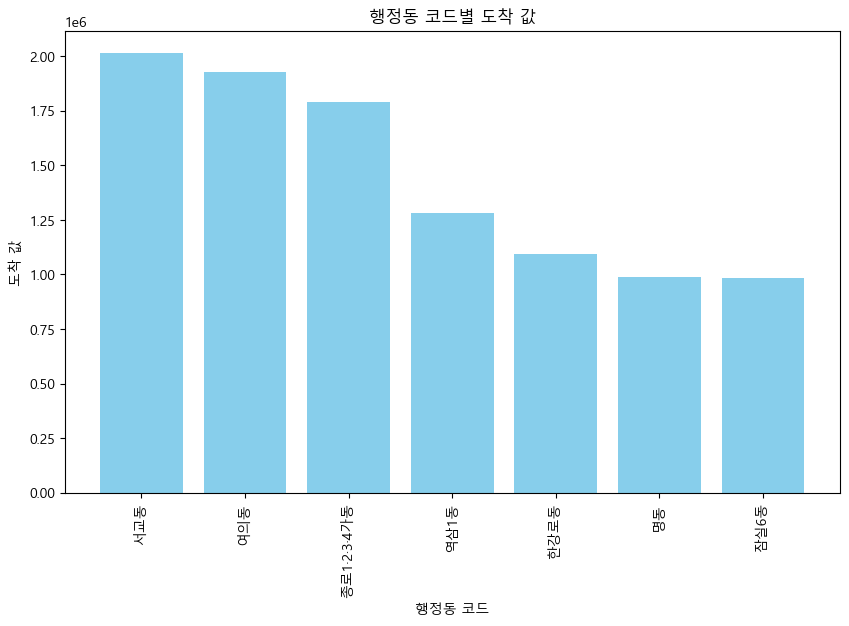

In [25]:
plt.figure(figsize=(10, 6)) 
plt.bar(top_50["도착 행정동 코드"], top_50["이동인구(평균)"], color='skyblue')
plt.rc('font', family='Malgun Gothic') #이거안하면 한글 폰트가 깨짐
plt.xticks(rotation=90)
plt.xlabel('행정동 코드')
plt.ylabel('도착 값')
plt.title('행정동 코드별 도착 값')

Text(0.5, 1.0, '행정동 코드별 도착 값')

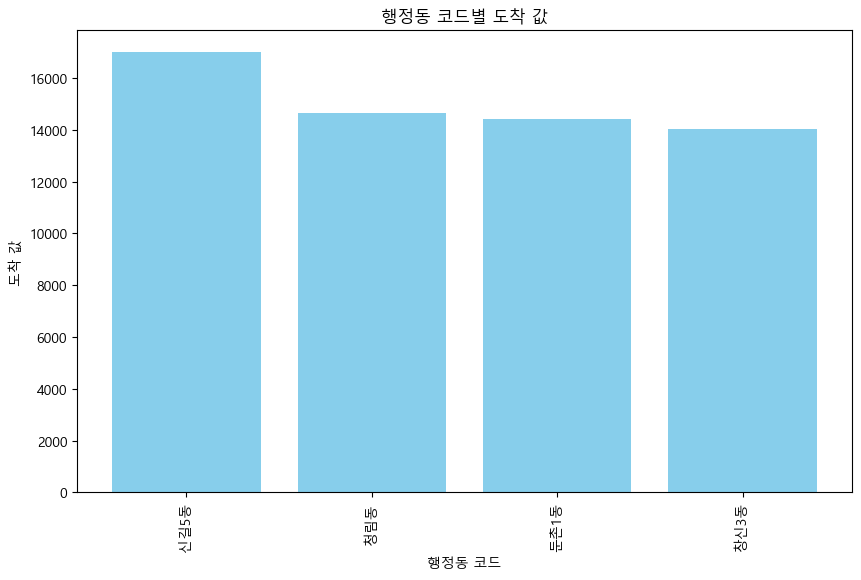

In [32]:
plt.figure(figsize=(10, 6)) 
plt.bar(bottom_50["도착 행정동 코드"], bottom_50["이동인구(평균)"], color='skyblue')
plt.rc('font', family='Malgun Gothic') 
plt.xticks(rotation=90)
plt.xlabel('행정동 코드')
plt.ylabel('도착 값')
plt.title('행정동 코드별 도착 값')

- 나이 분석 (나이를 다 분류해준 뒤 비율로 바꾸고, Merge해줌)

In [34]:
moving_df = total.copy()

In [35]:
F10 = moving_df[(moving_df["성별"] == "F") & (moving_df["나이"] =="10")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
M10 = moving_df[(moving_df["성별"] == "M") & (moving_df["나이"] =="10")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
F2030 = moving_df[(moving_df["성별"] == "F") & (moving_df["나이"] =="20-30")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
M2030 = moving_df[(moving_df["성별"] == "M") & (moving_df["나이"] =="20-30")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
F4050 = moving_df[(moving_df["성별"] == "F") & (moving_df["나이"] =="40-50")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
M4050 = moving_df[(moving_df["성별"] == "M") & (moving_df["나이"] =="40-50")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
F60 = moving_df[(moving_df["성별"] == "F") & (moving_df["나이"] =="60-")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)
M60 = moving_df[(moving_df["성별"] =="M") & (moving_df["나이"] =="60-")].groupby(["도착 행정동 코드"]).sum()["이동인구(합)"].reset_index().sort_values(by="이동인구(합)", ascending=False)

In [36]:
F10["지역별 선호비율"] = F10["이동인구(합)"] /F10["이동인구(합)"].sum() * 100
M10["지역별 선호비율"] = M10["이동인구(합)"] /M10["이동인구(합)"].sum() * 100
F2030["지역별 선호비율"] = F2030["이동인구(합)"] /F2030["이동인구(합)"].sum() * 100
M2030["지역별 선호비율"] = M2030["이동인구(합)"] /M2030["이동인구(합)"].sum() * 100
F4050["지역별 선호비율"] = F4050["이동인구(합)"] /F4050["이동인구(합)"].sum() * 100
M4050["지역별 선호비율"] = M4050["이동인구(합)"] /M4050["이동인구(합)"].sum() * 100
F60["지역별 선호비율"] = F60["이동인구(합)"] /F60["이동인구(합)"].sum() * 100
M60["지역별 선호비율"] = M60["이동인구(합)"] /M60["이동인구(합)"].sum() * 100

In [37]:
merge10 = pd.merge(F10,M10, how = "left",on="도착 행정동 코드", suffixes=('_F10','_M10'))[["도착 행정동 코드","지역별 선호비율_F10","지역별 선호비율_M10"]]
merge2030 =  pd.merge(F2030,M2030, how = "left",on="도착 행정동 코드", suffixes=('_F2030','_M2030'))[["도착 행정동 코드","지역별 선호비율_F2030","지역별 선호비율_M2030"]]
merge4050 =  pd.merge(F4050,M4050, how = "left",on="도착 행정동 코드", suffixes=('_F4050','_M4050'))[["도착 행정동 코드","지역별 선호비율_F4050","지역별 선호비율_M4050"]]
merge60 = pd.merge(F60,M60, how = "left",on="도착 행정동 코드", suffixes=('_F60','_M60'))[["도착 행정동 코드","지역별 선호비율_F60","지역별 선호비율_M60"]]

In [38]:
from functools import reduce
total = [merge10, merge2030, merge4050, merge60]
age_sex_merged = reduce(lambda left, right: pd.merge(left, right, on='도착 행정동 코드'), total)
age_sex_merged

,도착 행정동 코드,지역별 선호비율_F10,지역별 선호비율_M10,지역별 선호비율_F2030,지역별 선호비율_M2030,지역별 선호비율_F4050,지역별 선호비율_M4050,지역별 선호비율_F60,지역별 선호비율_M60
0,서교동,3.501386,1.938152,4.777345,3.941781,1.137429,1.034650,0.613880,0.555046
1,잠실3동,2.425818,1.857567,0.996811,0.766973,0.853231,0.632221,0.660172,0.450343
2,여의동,1.686079,1.522057,2.189138,1.949753,1.395353,1.348888,1.428229,1.185986
3,역삼1동,1.466531,1.187736,2.569678,2.656021,1.175023,1.306543,0.946933,1.029030
4,종로1·2·3·4가동,1.443665,1.133782,2.171119,2.113385,1.571615,1.438150,1.457488,2.309121
...,...,...,...,...,...,...,...,...,...
418,신길5동,0.025711,0.031847,0.021015,0.023692,0.036804,0.046568,0.040610,0.047772
419,청림동,0.023576,0.030571,0.013772,0.014952,0.025587,0.026278,0.033329,0.028936
420,가리봉동,0.016584,0.016717,0.027979,0.047729,0.044750,0.084973,0.043745,0.059747
421,창신3동,0.013589,0.015952,0.009447,0.011793,0.015197,0.018314,0.019334,0.016045


In [39]:
age_sex_corr = age_sex_merged.iloc[:,1:].corr()
age_sex_corr

,지역별 선호비율_F10,지역별 선호비율_M10,지역별 선호비율_F2030,지역별 선호비율_M2030,지역별 선호비율_F4050,지역별 선호비율_M4050,지역별 선호비율_F60,지역별 선호비율_M60
지역별 선호비율_F10,1.000000,0.960244,0.870740,0.857554,0.830176,0.790620,0.687786,0.582289
지역별 선호비율_M10,0.960244,1.000000,0.768784,0.773544,0.854604,0.822363,0.729324,0.619190
지역별 선호비율_F2030,0.870740,0.768784,1.000000,0.985780,0.812082,0.798341,0.673751,0.607628
지역별 선호비율_M2030,0.857554,0.773544,0.985780,1.000000,0.822248,0.829368,0.697106,0.647848
지역별 선호비율_F4050,0.830176,0.854604,0.812082,0.822248,1.000000,0.977260,0.933728,0.846826
지역별 선호비율_M4050,0.790620,0.822363,0.798341,0.829368,0.977260,1.000000,0.925761,0.882035
지역별 선호비율_F60,0.687786,0.729324,0.673751,0.697106,0.933728,0.925761,1.000000,0.930056
지역별 선호비율_M60,0.582289,0.619190,0.607628,0.647848,0.846826,0.882035,0.930056,1.000000


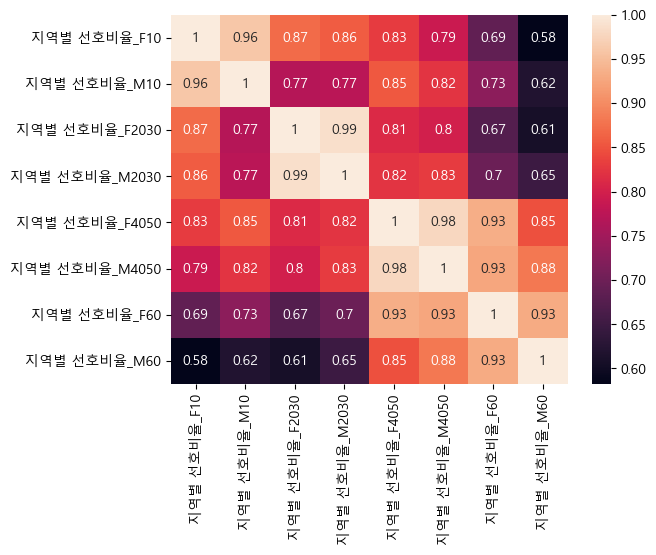

In [45]:
ax = sns.heatmap(age_sex_corr, annot=True)

성별보단 나이의 차이가 선호지역에 영향을 미침

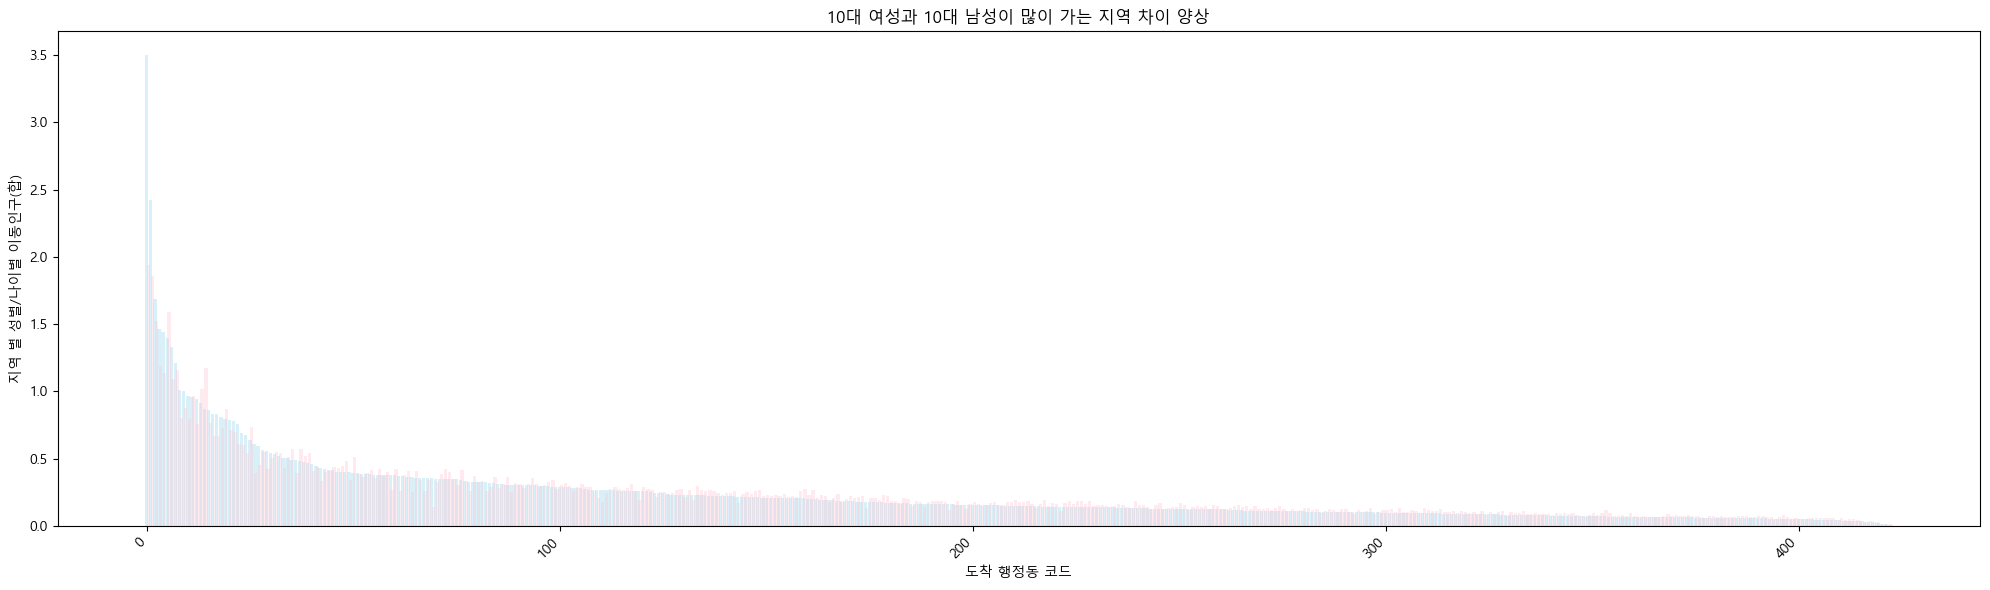

In [47]:
plt.figure(figsize=(20, 6))

X = age_sex_merged["도착 행정동 코드"].unique()
X_aixs = np.arange(len(X))

plt.bar(X_aixs - 0.2, age_sex_merged['지역별 선호비율_F10'], color='skyblue', label ="10대 여자", alpha=0.3)
plt.bar(X_aixs + 0.2, age_sex_merged['지역별 선호비율_M10'], color='pink', label ="10대 남자", alpha =0.3)

plt.xlabel('도착 행정동 코드')
plt.ylabel('지역 별 성별/나이별 이동인구(합)')
plt.title('10대 여성과 10대 남성이 많이 가는 지역 차이 양상')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

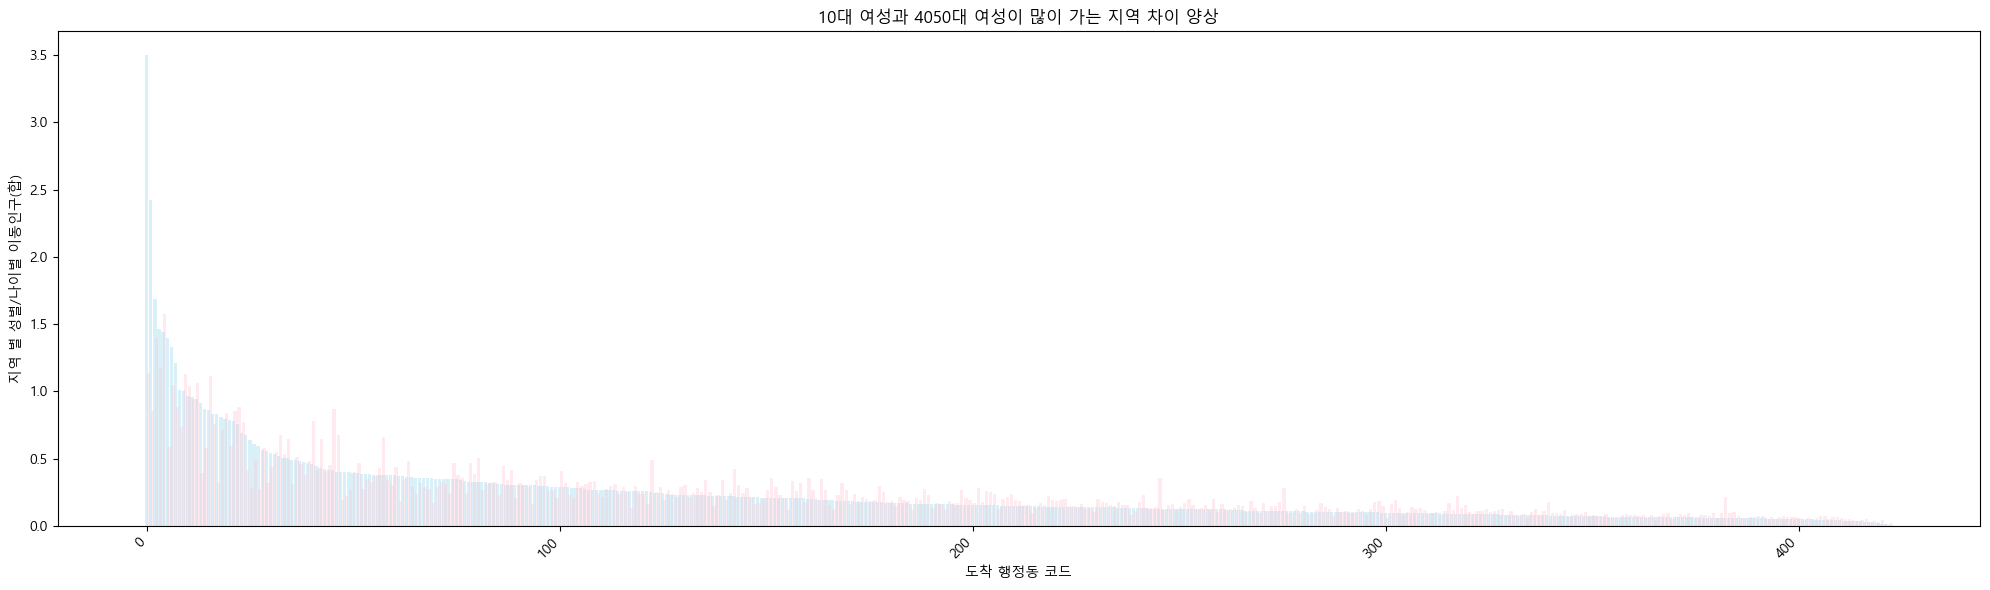

In [48]:
plt.figure(figsize=(20, 6))

X = age_sex_merged["도착 행정동 코드"].unique()
X_aixs = np.arange(len(X))

plt.bar(X_aixs - 0.2, age_sex_merged['지역별 선호비율_F10'], color='skyblue', label ="10대 여자", alpha=0.3)
plt.bar(X_aixs + 0.2, age_sex_merged['지역별 선호비율_F4050'], color='pink', label ="10대 남자", alpha =0.3)

plt.xlabel('도착 행정동 코드')
plt.ylabel('지역 별 성별/나이별 이동인구(합)')
plt.title('10대 여성과 4050대 여성이 많이 가는 지역 차이 양상')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

10대 여성과 10대 남성은 선호하는 지역의 양상이 비슷한 반면 4050대는 10대만큼 압도적인 선호도가 존재하지 않으며 위의 10대 여성 /남성을 비교한 그래프 보다 좀 더 그래프가 일치하지 않았다

### 상권 데이터 분석

- 유사 업종 점포수와 점포수 비교

In [51]:
num_diff = list(com['유사_업종_점포_수'] - com['점포_수'])
unique_values = np.unique(num_diff)
print(unique_values)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 137 139 141 144 147 149 172 176
 178 180 183 185 186 188 189]


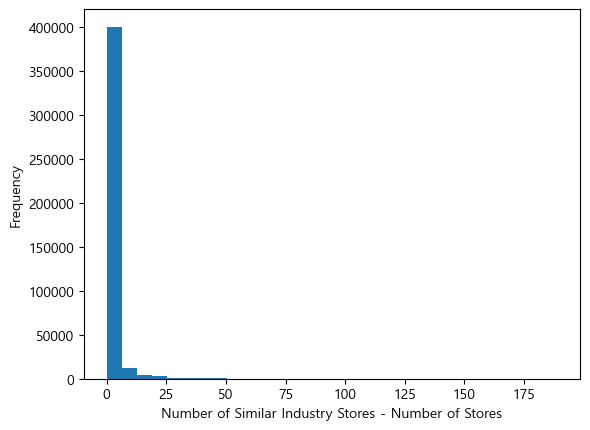

In [52]:
plt.hist(num_diff, bins=30)
plt.xlabel('Number of Similar Industry Stores - Number of Stores')
plt.ylabel('Frequency')
plt.show()

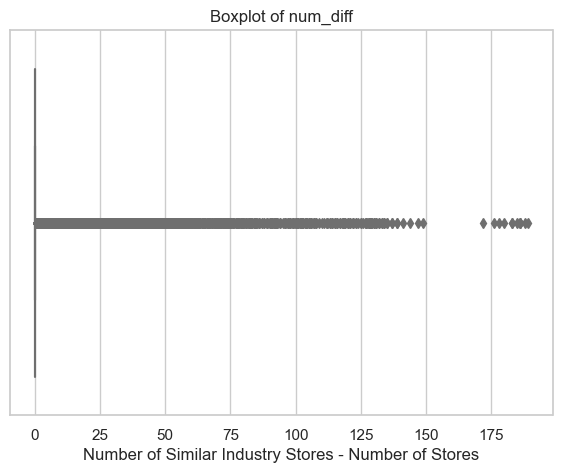

In [53]:
sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))

sns.boxplot(x=num_diff, color='skyblue')
plt.title('Boxplot of num_diff')
plt.xlabel('Number of Similar Industry Stores - Number of Stores')
plt.show()

대부분의 경우 두개가 동일하고 나머지는 이상치이기때문에 두 컬럼 중 하나만 사용해도 된다는 결론을 냄

- 서비스 업종 값

In [56]:
print(com['서비스_업종_코드_명'].unique())  
print("업종 종류는", len(com["서비스_업종_코드_명"].unique()))

['한식음식점' '중식음식점' '일식음식점' '양식음식점' '제과점' '패스트푸드점' '치킨전문점' '분식전문점' '호프-간이주점'
 '커피-음료' '일반교습학원' '외국어학원' '예술학원' '스포츠 강습' '일반의원' '치과의원' '한의원' '변호사사무소'
 '기타법무서비스' '세무사사무소' '당구장' '골프연습장' 'PC방' '전자게임장' '자동차수리' '자동차미용' '미용실'
 '네일숍' '피부관리실' '세탁소' '가전제품수리' '부동산중개업' '여관' '게스트하우스' '고시원' '노래방' '녹음실'
 '사진관' '통번역서비스' '건축물청소' '여행사' '비디오/서적임대' '의류임대' '슈퍼마켓' '편의점' '컴퓨터및주변장치판매'
 '핸드폰' '주류도매' '미곡판매' '육류판매' '수산물판매' '청과상' '반찬가게' '일반의류' '유아의류' '신발' '가방'
 '안경' '시계및귀금속' '의약품' '의료기기' '서적' '문구' '화장품' '미용재료' '운동/경기용품' '완구' '섬유제품'
 '화초' '애완동물' '가구' '가전제품' '철물점' '인테리어' '조명용품' '자동차부품' '모터사이클및부품' '재생용품 판매점'
 '예술품' '전자상거래업' '컴퓨터학원' '동물병원' '변리사사무소' '법무사사무소' '회계사사무소' '볼링장' '기타오락장'
 '복권방' '통신기기수리' '스포츠클럽' '독서실' '가정용품임대' '한복점' '악기' '주유소' 'DVD방' '모터사이클수리'
 '중고차판매' '자전거 및 기타운송장비' '중고가구']
업종 종류는 100


- 상위 업종 비교

In [58]:
top_service_per_region = com.loc[com.groupby(['행정동_코드_명', 'year', 'quarter'])['유사_업종_점포_수'].idxmax()]
top_service_per_region[["행정동_코드_명","서비스_업종_코드_명"]].drop_duplicates()

,행정동_코드_명,서비스_업종_코드_명
32729,가락1동,청과상
32751,가락2동,한식음식점
173522,가락2동,전자상거래업
32593,가락본동,한식음식점
21831,가리봉동,한식음식점
...,...,...
248923,후암동,전자상거래업
7335,휘경1동,한식음식점
147973,휘경1동,전자상거래업
7488,휘경2동,전자상거래업


In [60]:
top_service_ = top_service_per_region.groupby(["행정동_코드_명","서비스_업종_코드_명"])["서비스_업종_코드"].count().reset_index()

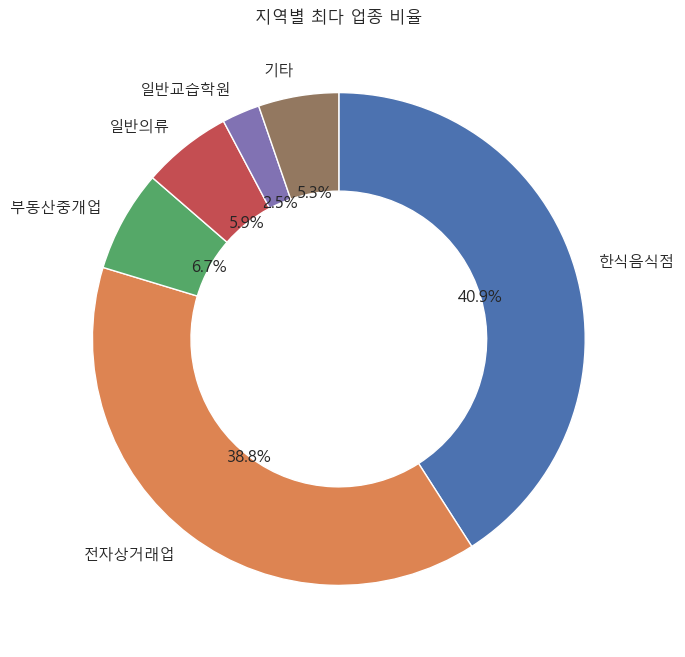

In [63]:
df = pd.DataFrame(top_service_)

service_percentage = df['서비스_업종_코드_명'].value_counts(normalize=True) * 100

threshold = 1
service_percentage['기타'] = service_percentage[service_percentage < threshold].sum()
service_percentage = service_percentage[service_percentage >= threshold]

plt.figure(figsize=(8, 8))
plt.rc('font', family='Malgun Gothic') 

plt.pie(service_percentage, labels=service_percentage.index, autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.4))

plt.title('지역별 최다 업종 비율')

plt.show()


대부분의 경우 한식음식점과 전자상거래업이 많은 비율을 차지함

몇 개의 동네만 예시로 찾아보면

In [64]:
#연희동 : 상위 업종이 한식-> 전자상거래로변경
top_service_per_region[top_service_per_region["행정동_코드_명"] == "연희동"]

,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,폐업_률,year,quarter,점포_변화_율
15908,연희동,CS100001,한식음식점,156,171,5,4,2020,1,1
51100,연희동,CS300043,전자상거래업,173,173,7,1,2020,2,6
86244,연희동,CS300043,전자상거래업,185,185,7,0,2020,3,7
121397,연희동,CS300043,전자상거래업,198,198,7,0,2020,4,7
156604,연희동,CS300043,전자상거래업,207,207,11,0,2021,1,11
191858,연희동,CS300043,전자상거래업,223,224,8,0,2021,2,8
227123,연희동,CS300043,전자상거래업,239,240,8,2,2021,3,6
262434,연희동,CS300043,전자상거래업,274,275,14,2,2021,4,12
297785,연희동,CS300043,전자상거래업,267,268,0,3,2022,1,-3
333110,연희동,CS300043,전자상거래업,254,255,0,5,2022,2,-5


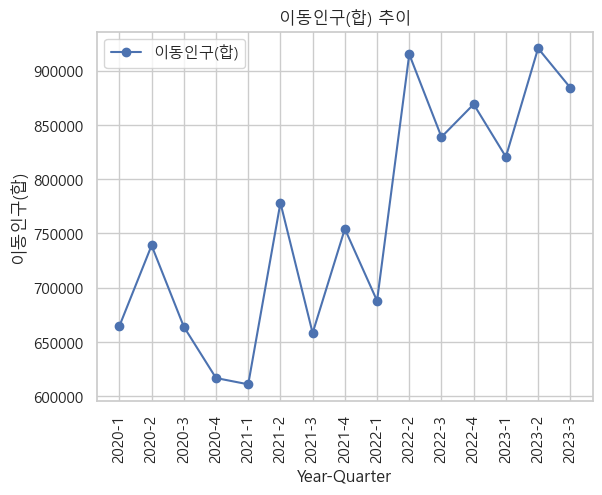

In [74]:
cnt = moving_df[moving_df["도착 행정동 코드"] == "연희동"].groupby(["year","quarter"])["이동인구(합)"].sum().reset_index()

cnt = cnt[:-1] #마지막 쿼터는 아직 전부 집계되지 않아 제거

fig, ax = plt.subplots()

ax.plot(range(len(cnt["year"])), cnt["이동인구(합)"], marker='o', label='이동인구(합)')

ax.set_xticks(range(len(cnt["year"])))
ax.set_xticklabels([f'{year}-{quarter}' for year, quarter in zip(cnt["year"], cnt["quarter"])])

ax.set_xlabel('Year-Quarter')
ax.set_ylabel('이동인구(합)')
ax.set_title('이동인구(합) 추이')
plt.rc('font', family='Malgun Gothic')
plt.xticks(rotation=90)
ax.legend()

plt.show()

In [66]:
#2. 광장동 : 역시 코로나를 기점으로 한식 -> 전자상거래업으로 상위 업종이 변경됨
top_service_per_region[top_service_per_region["행정동_코드_명"] == "광장동"]

,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,폐업_률,year,quarter,점포_변화_율
5760,광장동,CS100001,한식음식점,78,86,7,8,2020,1,-1
40849,광장동,CS100001,한식음식점,80,88,3,1,2020,2,2
76069,광장동,CS300043,전자상거래업,91,91,8,0,2020,3,8
111221,광장동,CS300043,전자상거래업,96,96,5,0,2020,4,5
146398,광장동,CS300043,전자상거래업,114,115,20,3,2021,1,17
181650,광장동,CS300043,전자상거래업,132,133,14,0,2021,2,14
216905,광장동,CS300043,전자상거래업,150,151,13,1,2021,3,12
252191,광장동,CS300043,전자상거래업,174,175,15,1,2021,4,14
287559,광장동,CS300043,전자상거래업,172,173,1,2,2022,1,-1
322893,광장동,CS300043,전자상거래업,171,172,0,1,2022,2,-1


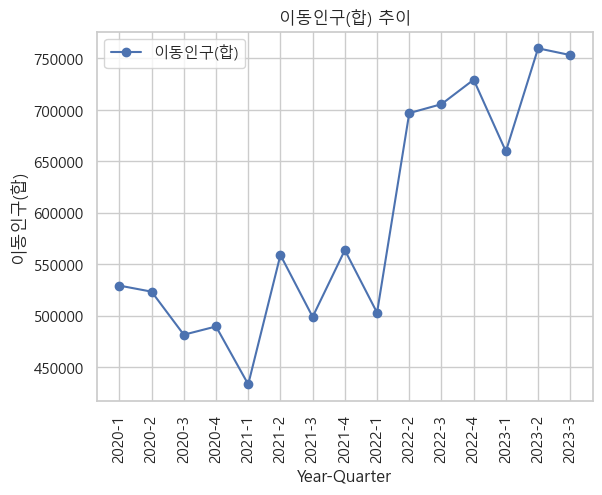

In [75]:
cnt = moving_df[moving_df["도착 행정동 코드"] == "광장동"].groupby(["year","quarter"])["이동인구(합)"].sum().reset_index()

cnt = cnt[:-1] #마지막 쿼터는 아직 전부 집계되지 않아 제거

fig, ax = plt.subplots()

ax.plot(range(len(cnt["year"])), cnt["이동인구(합)"], marker='o', label='이동인구(합)')

ax.set_xticks(range(len(cnt["year"])))
ax.set_xticklabels([f'{year}-{quarter}' for year, quarter in zip(cnt["year"], cnt["quarter"])])

ax.set_xlabel('Year-Quarter')
ax.set_ylabel('이동인구(합)')
ax.set_title('이동인구(합) 추이')
plt.rc('font', family='Malgun Gothic') 
plt.xticks(rotation=90)

ax.legend()

plt.show()

더 많은 지역을 그려봤지만 생략하겠음. 대다수의 경우에서 코로나가 장기화될 전망을 보인 2021년부터 전자상거래업의 개업률이 매우 높았고 코로나가 완화된 시점부터 전자상거래업의 개업률 상승 폭이 좁다 폐업률이 높아지기 시작함

이동인구의 추이는 코로나의 영향이 너무 강력해 상권보다는 코로나에 더 영향을 받은 것 같았다 (실제 전체 유동인구 총합의 움직임과 대부분의 지역이 비슷한 움직임을 따름)

* 기타지역이 상위업종인 경우 특정상품특화지역인 경우가 대다수였음

In [80]:
# 신발 -> 창신1동 : 동대문 신발 도매 상가 위치
top_service_[(top_service_["서비스_업종_코드_명"]  =="신발") ].iloc[:,:-1]

,행정동_코드_명,서비스_업종_코드_명
576,창신1동,신발


In [81]:
# 시계 및 귀금속 -> 종로 : 귀금속거리
top_service_[(top_service_["서비스_업종_코드_명"]  =="시계및귀금속") ].iloc[:,:-1]

,행정동_코드_명,서비스_업종_코드_명
547,종로1·2·3·4가동,시계및귀금속


### 두 데이터 간 상관관계 분석

In [82]:
market = com.copy()

In [88]:
#한식음식점
market_k_food = market[market["서비스_업종_코드_명"] == "한식음식점"]
#전자상거래업
market_elec= market[market["서비스_업종_코드_명"] == "전자상거래업"]
# 지역별 유동인구 (merge용)
region = moving_df.groupby(["도착 행정동 코드", "year", "quarter"])["이동인구(합)"].sum().reset_index()
region_ =region[region["year"]!= 2023]
region_['rank'] = region_['이동인구(합)'].rank(method="average", ascending=False) #유동인구순위추가

In [89]:
region_

,도착 행정동 코드,year,quarter,이동인구(합),rank
0,가락1동,2020,1,518979.62,1290.0
1,가락1동,2020,2,541298.19,1188.0
2,가락1동,2020,3,497626.60,1390.0
3,가락1동,2020,4,532501.79,1234.0
4,가락1동,2021,1,505503.21,1356.0
...,...,...,...,...,...
6759,흑석동,2021,4,417156.18,1830.0
6760,흑석동,2022,1,361147.29,2175.0
6761,흑석동,2022,2,475648.49,1511.0
6762,흑석동,2022,3,455375.15,1608.0


In [86]:
market_k_food.sort_values(by= "유사_업종_점포_수", ascending=False)

,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,폐업_률,year,quarter,점포_변화_율
277019,역삼1동,CS100001,한식음식점,1055,1180,5,3,2021,4,2
347679,역삼1동,CS100001,한식음식점,1058,1174,4,4,2022,2,0
312353,역삼1동,CS100001,한식음식점,1051,1171,2,3,2022,1,-1
241667,역삼1동,CS100001,한식음식점,1037,1166,5,4,2021,3,1
383024,역삼1동,CS100001,한식음식점,1047,1162,3,4,2022,3,-1
...,...,...,...,...,...,...,...,...,...,...
348053,개포1동,CS100001,한식음식점,4,5,0,0,2022,2,0
101118,개포1동,CS100001,한식음식점,4,5,0,0,2020,3,0
206764,개포1동,CS100001,한식음식점,4,5,0,0,2021,2,0
242039,개포1동,CS100001,한식음식점,4,5,0,0,2021,3,0


In [90]:
region_.sort_values(by = "이동인구(합)", ascending=False)[:10]

,도착 행정동 코드,year,quarter,이동인구(합),rank
3003,서교동,2022,4,5829760.83,1.0
3002,서교동,2022,3,5481570.21,2.0
3001,서교동,2022,2,5410784.07,3.0
5643,종로1·2·3·4가동,2022,4,5006059.47,4.0
4425,여의동,2022,2,4603610.11,5.0
4427,여의동,2022,4,4547911.21,6.0
5641,종로1·2·3·4가동,2022,2,4461343.47,7.0
2999,서교동,2021,4,4256203.66,8.0
5642,종로1·2·3·4가동,2022,3,4188968.96,9.0
4426,여의동,2022,3,3937176.29,10.0


In [91]:
market_k_food["year"] = market_k_food["year"].astype(int)
market_k_food["quarter"] = market_k_food["quarter"].astype(int)
market_elec["year"] = market_elec["year"].astype(int)
market_elec["quarter"] = market_elec["quarter"].astype(int)

In [92]:
join_columns_df1 = ['행정동_코드_명', 'year', 'quarter']
join_columns_df2 = ['도착 행정동 코드', 'year', 'quarter']

In [94]:
merged_K_food = pd.merge(market_k_food, region_, left_on=join_columns_df1, right_on=join_columns_df2)
merged_elec =  pd.merge(market_elec, region_, left_on=join_columns_df1, right_on=join_columns_df2)

In [95]:
merged_elec

,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,폐업_률,year,quarter,점포_변화_율,도착 행정동 코드,이동인구(합),rank
0,청운효자동,CS300043,전자상거래업,39,39,3,8,2020,1,-5,청운효자동,315015.49,2541.0
1,사직동,CS300043,전자상거래업,65,65,8,3,2020,1,5,사직동,700646.33,724.0
2,삼청동,CS300043,전자상거래업,8,8,13,0,2020,1,13,삼청동,200860.14,3572.0
3,부암동,CS300043,전자상거래업,41,41,5,0,2020,1,5,부암동,227842.11,3286.0
4,평창동,CS300043,전자상거래업,45,45,7,0,2020,1,7,평창동,245252.58,3116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5083,성내2동,CS300043,전자상거래업,148,148,0,4,2022,4,-4,성내2동,561840.90,1109.0
5084,성내3동,CS300043,전자상거래업,162,163,0,3,2022,4,-3,성내3동,981054.38,373.0
5085,길동,CS300043,전자상거래업,306,306,0,2,2022,4,-2,길동,1500718.90,147.0
5086,둔촌1동,CS300043,전자상거래업,1,1,0,0,2022,4,0,둔촌1동,41309.41,5045.0


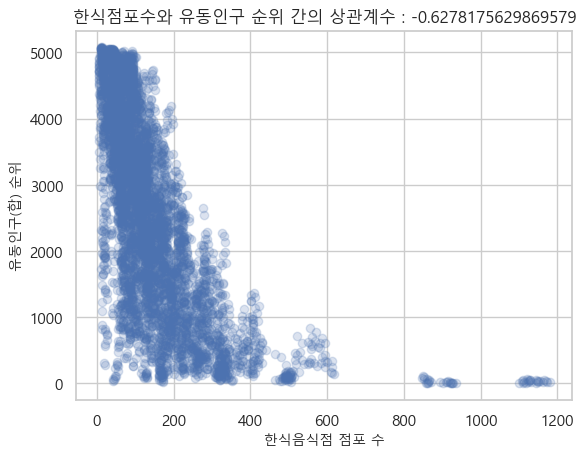

In [99]:
X = merged_K_food["유사_업종_점포_수"].values
Y = merged_K_food["rank"].values

import matplotlib.pyplot as plt
plt.scatter(X, Y, alpha=0.2)
plt.rc('font', family='Malgun Gothic') 
plt.title(f"한식점포수와 유동인구 순위 간의 상관계수 : {merged_K_food['유사_업종_점포_수'].corr(merged_K_food['rank'])}")
plt.xlabel("한식음식점 점포 수",fontsize=10)
plt.ylabel("유동인구(합) 순위", fontsize = 10)

plt.show()

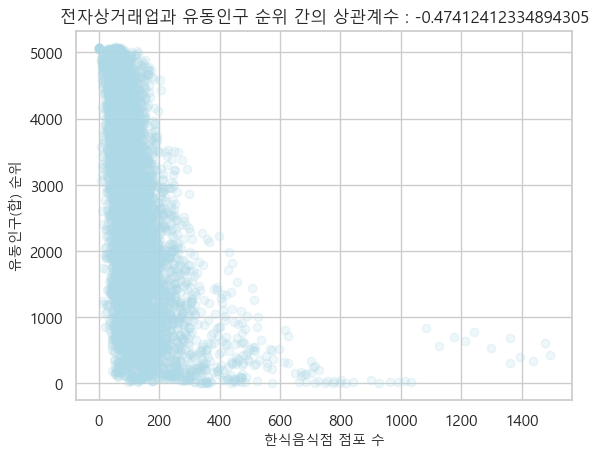

In [100]:
X = merged_elec["유사_업종_점포_수"].values
Y = merged_elec["rank"].values

import matplotlib.pyplot as plt
plt.scatter(X, Y, alpha=0.2, color="lightblue")
plt.rc('font', family='Malgun Gothic') 
plt.title(f"전자상거래업과 유동인구 순위 간의 상관계수 : {merged_elec['유사_업종_점포_수'].corr(merged_elec['rank'])}")
plt.xlabel("한식음식점 점포 수",fontsize=10)
plt.ylabel("유동인구(합) 순위", fontsize = 10)

plt.show()

In [102]:
total_market = market.groupby(["행정동_코드_명", "year","quarter"])["유사_업종_점포_수"].sum().reset_index()
total_market["year"] = total_market["year"].astype(int)
total_market["quarter"] = total_market["quarter"].astype(int)

In [103]:
merged_df_ = pd.merge(total_market, region_, left_on=join_columns_df1, right_on=join_columns_df2)

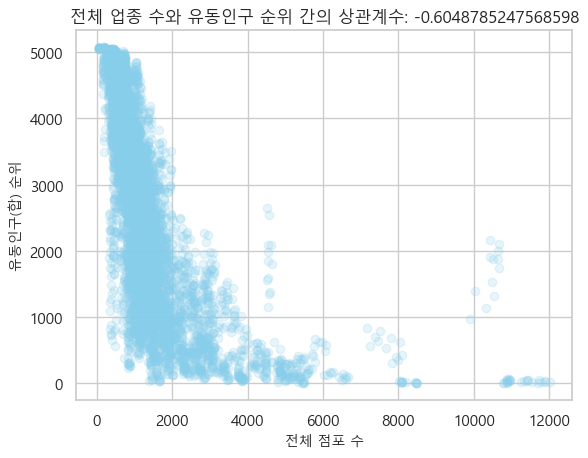

In [104]:
X = merged_df_["유사_업종_점포_수"].values
Y = merged_df_["rank"].values

import matplotlib.pyplot as plt
plt.scatter(X, Y, alpha=0.2, color="skyblue")

plt.title(f"전체 업종 수와 유동인구 순위 간의 상관계수: {merged_df_['유사_업종_점포_수'].corr(merged_df_['rank'])}")
plt.xlabel("전체 점포 수",fontsize=10)
plt.ylabel("유동인구(합) 순위", fontsize = 10)

plt.show()

## 예측 모델링

* 서비스 업종은 행정동별 가장 많은 업종이 있는 ['한식음식점','전자상거래업','일반의류','부동산중개업','슈퍼마켓']으로 데이터 사이즈를 줄인다.
* 요일과 나이는 큰 차이가 없었기에 total 데이터를 행정동/연도/분기로 다시 전처리

In [117]:
total = pd.read_csv("total.csv")
total = total.groupby(['도착 행정동 코드','year','quarter'])['이동인구(합)'].sum().reset_index()

In [121]:
com = pd.read_csv("market.csv")

In [122]:
use_idx = [ True if i in ['한식음식점','전자상거래업','일반의류','부동산중개업','슈퍼마켓'] else False for i in com['서비스_업종_코드_명']]
com = com.loc[use_idx,: ]

com = pd.pivot_table(data=com, index=['행정동_코드_명','year','quarter'],
                     columns=['서비스_업종_코드_명'],values=['유사_업종_점포_수'],
                     aggfunc='sum')
com.columns = ['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']
com.reset_index(inplace=True)
com

,행정동_코드_명,year,quarter,부동산중개업,슈퍼마켓,일반의류,전자상거래업,한식음식점
0,가락1동,2020,1,133.0,44.0,10.0,61.0,77.0
1,가락1동,2020,2,138.0,45.0,10.0,68.0,76.0
2,가락1동,2020,3,144.0,46.0,11.0,76.0,78.0
3,가락1동,2020,4,147.0,45.0,12.0,82.0,79.0
4,가락1동,2021,1,140.0,44.0,13.0,101.0,79.0
...,...,...,...,...,...,...,...,...
5083,흑석동,2021,4,136.0,34.0,37.0,139.0,171.0
5084,흑석동,2022,1,133.0,35.0,37.0,135.0,172.0
5085,흑석동,2022,2,129.0,36.0,36.0,128.0,170.0
5086,흑석동,2022,3,126.0,35.0,35.0,124.0,161.0


- 데이터 병합

In [123]:
merged = pd.merge(left=total,right=com, left_on=['도착 행정동 코드','year','quarter'], right_on=['행정동_코드_명'
,'year','quarter'],how='inner')

merged.drop(columns=['행정동_코드_명'], inplace=True)
merged.fillna(0, inplace=True)

In [124]:
merged

,도착 행정동 코드,year,quarter,이동인구(합),부동산중개업,슈퍼마켓,일반의류,전자상거래업,한식음식점
0,가락1동,2020,1,518979.62,133.0,44.0,10.0,61.0,77.0
1,가락1동,2020,2,541298.19,138.0,45.0,10.0,68.0,76.0
2,가락1동,2020,3,497626.60,144.0,46.0,11.0,76.0,78.0
3,가락1동,2020,4,532501.79,147.0,45.0,12.0,82.0,79.0
4,가락1동,2021,1,505503.21,140.0,44.0,13.0,101.0,79.0
...,...,...,...,...,...,...,...,...,...
5071,흑석동,2021,4,417156.18,136.0,34.0,37.0,139.0,171.0
5072,흑석동,2022,1,361147.29,133.0,35.0,37.0,135.0,172.0
5073,흑석동,2022,2,475648.49,129.0,36.0,36.0,128.0,170.0
5074,흑석동,2022,3,455375.15,126.0,35.0,35.0,124.0,161.0


- 행정동 별 인구 예측

* Train : 2020 1Q ~ 2021 4Q
* Test : 2022 3Q ~ 2022 4Q

In [125]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

In [126]:
merged.sort_values(by=['도착 행정동 코드','year','quarter'], inplace=True)
merged

,도착 행정동 코드,year,quarter,이동인구(합),부동산중개업,슈퍼마켓,일반의류,전자상거래업,한식음식점
0,가락1동,2020,1,518979.62,133.0,44.0,10.0,61.0,77.0
1,가락1동,2020,2,541298.19,138.0,45.0,10.0,68.0,76.0
2,가락1동,2020,3,497626.60,144.0,46.0,11.0,76.0,78.0
3,가락1동,2020,4,532501.79,147.0,45.0,12.0,82.0,79.0
4,가락1동,2021,1,505503.21,140.0,44.0,13.0,101.0,79.0
...,...,...,...,...,...,...,...,...,...
5071,흑석동,2021,4,417156.18,136.0,34.0,37.0,139.0,171.0
5072,흑석동,2022,1,361147.29,133.0,35.0,37.0,135.0,172.0
5073,흑석동,2022,2,475648.49,129.0,36.0,36.0,128.0,170.0
5074,흑석동,2022,3,455375.15,126.0,35.0,35.0,124.0,161.0


In [127]:
train_idx = [ True if i in [2020,2021] else False for i in merged['year']]
test_idx = [ True if i in [2022] else False for i in merged['year']]

train = merged[train_idx]
test = merged[test_idx]

* 행정동 label encoding

In [128]:
district = train['도착 행정동 코드'].unique()

le = LabelEncoder()
le.fit(district)

train['행정동_LE'] = le.transform(train['도착 행정동 코드'])
test['행정동_LE'] = le.transform(test['도착 행정동 코드'])

train

,도착 행정동 코드,year,quarter,이동인구(합),부동산중개업,슈퍼마켓,일반의류,전자상거래업,한식음식점,행정동_LE
0,가락1동,2020,1,518979.62,133.0,44.0,10.0,61.0,77.0,0
1,가락1동,2020,2,541298.19,138.0,45.0,10.0,68.0,76.0,0
2,가락1동,2020,3,497626.60,144.0,46.0,11.0,76.0,78.0,0
3,가락1동,2020,4,532501.79,147.0,45.0,12.0,82.0,79.0,0
4,가락1동,2021,1,505503.21,140.0,44.0,13.0,101.0,79.0,0
...,...,...,...,...,...,...,...,...,...,...
5067,흑석동,2020,4,369236.11,136.0,35.0,37.0,63.0,181.0,422
5068,흑석동,2021,1,330674.30,128.0,34.0,37.0,88.0,175.0,422
5069,흑석동,2021,2,380442.00,132.0,34.0,36.0,102.0,176.0,422
5070,흑석동,2021,3,338332.17,133.0,35.0,37.0,122.0,172.0,422


- 정규화

In [129]:
scaler_migration = MinMaxScaler()
scaler_other = MinMaxScaler()

scaler_migration.fit(train[['이동인구(합)']])
scaler_other.fit(train[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']])

train[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']] = scaler_other.transform(train[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']])
test[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']] = scaler_other.transform(test[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점']])

train[['이동인구(합)']] = scaler_migration.transform(train[['이동인구(합)']])
test[['이동인구(합)']] = scaler_migration.transform(test[['이동인구(합)']])

train

,도착 행정동 코드,year,quarter,이동인구(합),부동산중개업,슈퍼마켓,일반의류,전자상거래업,한식음식점,행정동_LE
0,가락1동,2020,1,0.117679,0.127536,0.157480,0.000613,0.039597,0.065254,0
1,가락1동,2020,2,0.122948,0.132367,0.161417,0.000613,0.044295,0.064407,0
2,가락1동,2020,3,0.112637,0.138164,0.165354,0.000736,0.049664,0.066102,0
3,가락1동,2020,4,0.120871,0.141063,0.161417,0.000859,0.053691,0.066949,0
4,가락1동,2021,1,0.114497,0.134300,0.157480,0.000981,0.066443,0.066949,0
...,...,...,...,...,...,...,...,...,...,...
5067,흑석동,2020,4,0.082326,0.130435,0.122047,0.003926,0.040940,0.153390,422
5068,흑석동,2021,1,0.073222,0.122705,0.118110,0.003926,0.057718,0.148305,422
5069,흑석동,2021,2,0.084971,0.126570,0.118110,0.003803,0.067114,0.149153,422
5070,흑석동,2021,3,0.075029,0.127536,0.122047,0.003926,0.080537,0.145763,422


In [131]:
X_train, Y_train = train[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점','행정동_LE']],train['이동인구(합)']
X_test, Y_test = test[['부동산중개업','슈퍼마켓','일반의류','전자상거래업','한식음식점','행정동_LE']],test['이동인구(합)']

### Linear Regression

In [132]:
model1 = LinearRegression()
model1.fit(X_train, Y_train)
model1.score(X_test, Y_test)

0.53714981996466

In [134]:
import feature_selection as fsel

X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([Y_train, Y_test], axis=0, ignore_index=True)

fsel.backwardSelection(X, y, model_type='linear', elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
Eliminated : 일반의류
Regained :  일반의류
                            OLS Regression Results                            
Dep. Variable:                이동인구(합)   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     1470.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:02:09   Log-Likelihood:                 6680.5
No. Observations:                5076   AIC:                        -1.335e+04
Df Residuals:                    5069   BIC:                        -1.330e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

['intercept', '부동산중개업', '슈퍼마켓', '일반의류', '전자상거래업', '한식음식점', '행정동_LE']

### PCA 

변수들 간의 상관성을 고려하여 데이터를 새로운 기저로 변환하는 방법 중 하나로, 새로운 변수들(주성분)을 얻을 수 있고 이 변수들은 서로 상관성이 없음.
- 결과적으로는 결정계수 값이 0.05 정도 오름

In [136]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.95)  # 누적 설명된 분산이 95%가 되도록 설정
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 새로운 주성분으로 선형 회귀 모델 훈련
model = LinearRegression()
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

score = model.score(X_test_pca, y_test)
print(f'Model Score: {score}')

Mean Squared Error: 0.00544693821243386
Model Score: 0.5869940533131406


### Decision Tree Regressor
GridSearch를 활용해 하이퍼파라미터 튜닝
- max_depth, min_samples_split, min_samples_leaf

In [137]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

model2 = DecisionTreeRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.877431253416007

In [138]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model3 = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

test_r2 = best_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_r2}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test R^2 Score: 0.8888146294581838


#### 전자상거래업 제외

In [139]:
X_train, Y_train = train[['부동산중개업','슈퍼마켓','일반의류','한식음식점','행정동_LE']],train['이동인구(합)']
X_test, Y_test = test[['부동산중개업','슈퍼마켓','일반의류','한식음식점','행정동_LE']],test['이동인구(합)']

In [140]:
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([Y_train, Y_test], axis=0, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision Tree Regressor2
GridSearch를 활용해 하이퍼파라미터 튜닝

In [141]:
model4 = DecisionTreeRegressor()

model4.fit(X_train, y_train)
model4.score(X_test, y_test)

0.8908196506512038

In [142]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model5 = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model5, param_grid=param_grid, cv=5, scoring='r2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

test_r2 = best_model.score(X_test, y_test)
print(f"Test R^2 Score: {test_r2}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Test R^2 Score: 0.9023132987782087


- 변수 중요도

일반의류: 0.42686926994931707
한식음식점: 0.3917595336786346
부동산중개업: 0.07857645098572862
행정동_LE: 0.0575099991905393
슈퍼마켓: 0.04528474619578047


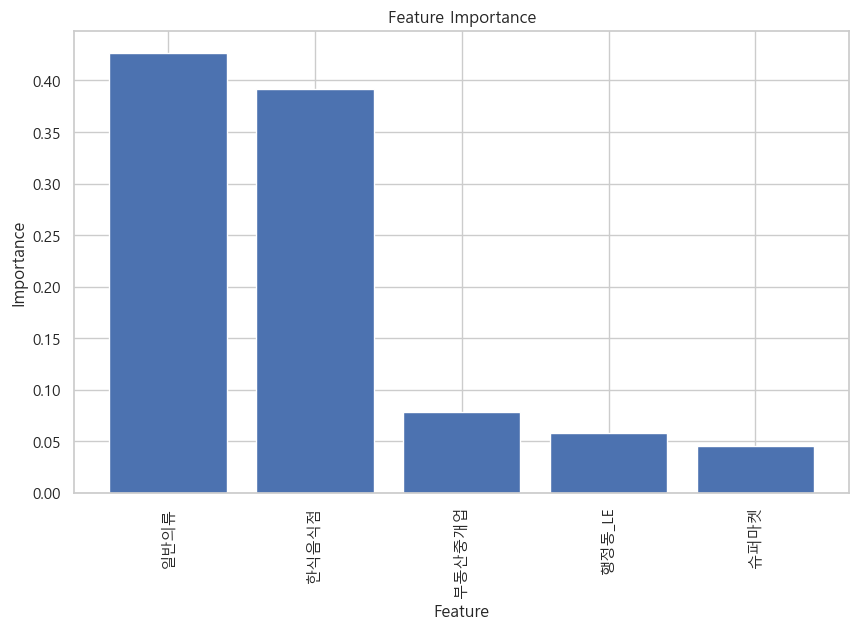

In [143]:
feature_importances = best_model.feature_importances_

indices = feature_importances.argsort()[::-1]  # 중요도 내림차순

for f in range(X_train.shape[1]):
    print(f"{X.columns[indices[f]]}: {feature_importances[indices[f]]}")

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

### Random Forest Regressor

In [144]:
from sklearn.ensemble import RandomForestRegressor

model6 = RandomForestRegressor(random_state=42)
model6.fit(X_train, y_train)
y_pred_rf = model6.predict(X_test)

score_rf = model6.score(X_test, y_test)
print(f'Model Score (Random Forest): {score_rf}')

Model Score (Random Forest): 0.927382928463057


In [ ]:
model_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=5, scoring='r2')

grid_search_rf.fit(X_train, y_train)
print("Best Hyperparameters (Random Forest):", grid_search_rf.best_params_)

best_model_rf = grid_search_rf.best_estimator_

test_r2_rf = best_model_rf.score(X_test, y_test)
print(f"Test R^2 Score (Random Forest): {test_r2_rf}")

- 변수 중요도

In [ ]:
feature_importances_rf = best_model_rf.feature_importances_

indices_rf = feature_importances_rf.argsort()[::-1]

for f in range(X_train.shape[1]):
    print(f"{X.columns[indices_rf[f]]}: {feature_importances_rf[indices_rf[f]]}")

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()